# Data Loading and preparation

Prepare for API and path

In [1]:
#All of the imports
from google.colab import drive
import os
import random
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
import sklearn.metrics as metrics
from torch.utils.data import random_split, DataLoader

In [2]:
! pip install kaggle

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! mkdir ~/.kaggle

In [5]:
! cp /content/drive/MyDrive/modern_analyltics/kaggle-API/kaggle.json ~/.kaggle/kaggle.json

cp: cannot stat '/content/drive/MyDrive/modern_analyltics/kaggle-API/kaggle.json': No such file or directory


Download dataset from Kaggle

In [6]:
! kaggle datasets download warcoder/tyre-quality-classification

Dataset URL: https://www.kaggle.com/datasets/warcoder/tyre-quality-classification
License(s): Attribution 4.0 International (CC BY 4.0)
100% 2.66G/2.66G [01:29<00:00, 40.0MB/s]
100% 2.66G/2.66G [01:29<00:00, 31.8MB/s]


In [7]:
! unzip tyre-quality-classification.zip
! mv "Digital images of defective and good condition tyres" Digital_images

Archive:  tyre-quality-classification.zip
  inflating: Digital images of defective and good condition tyres/defective/Defective (1).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (10).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (100).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1000).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1001).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1002).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1003).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1004).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1005).jpg  
  inflating: Digital images of defective and good condition tyres/defecti

Read image data

In [8]:
class TyreDataset(Dataset):
    def __init__(self, defective_dir, good_dir, transform=None):
        self.filepaths = []
        self.labels = []     # Labels (0=good, 1=defective)

        # Read defective folder
        for filename in os.listdir(defective_dir):
            if filename.endswith('.jpg'):
                self.filepaths.append(os.path.join(defective_dir, filename))
                self.labels.append(1)

        # Read good folder
        for filename in os.listdir(good_dir):
            if filename.endswith('.jpg'):
                self.filepaths.append(os.path.join(good_dir, filename))
                self.labels.append(0)

        # Shuffle
        combined = list(zip(self.filepaths, self.labels))
        random.shuffle(combined)
        self.filepaths, self.labels = zip(*combined)

        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Image transformation
        if self.transform:
            image = self.transform(image)

        return image, label


defective_dir = '/content/Digital_images/defective'
good_dir = '/content/Digital_images/good'

In [10]:
# Image transofrmation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize
    transforms.ToTensor(),         # Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pre-trained parameters from ImageNet dataset
])

# Create dataset
dataset = TyreDataset(defective_dir, good_dir, transform=transform)

In [11]:
# Output the size of original images
for i in range(5):
    file_path, label = dataset.filepaths[i], dataset.labels[i]
    original_image = Image.open(file_path).convert('RGB')
    print(f"Image {i+1}: Size = {original_image.size}, Label = {'Defective' if label == 1 else 'Good'}")

Image 1: Size = (1005, 1005), Label = Good
Image 2: Size = (4000, 1800), Label = Defective
Image 3: Size = (1800, 4000), Label = Good
Image 4: Size = (1800, 4000), Label = Good
Image 5: Size = (834, 834), Label = Good


In [ ]:
print(len(dataset))

1856


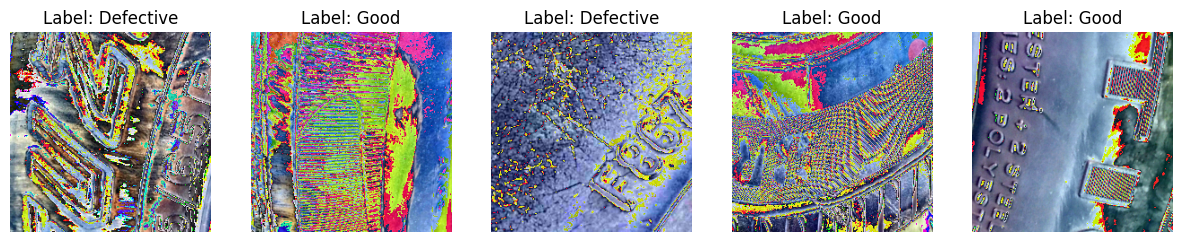

In [ ]:
# Display the first 5 images with labels
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    image, label = dataset[i]
    # Convert tensor image back to PIL image for display
    image = transforms.ToPILImage()(image)
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {'Defective' if label == 1 else 'Good'}")
    axes[i].axis('off')

plt.show()

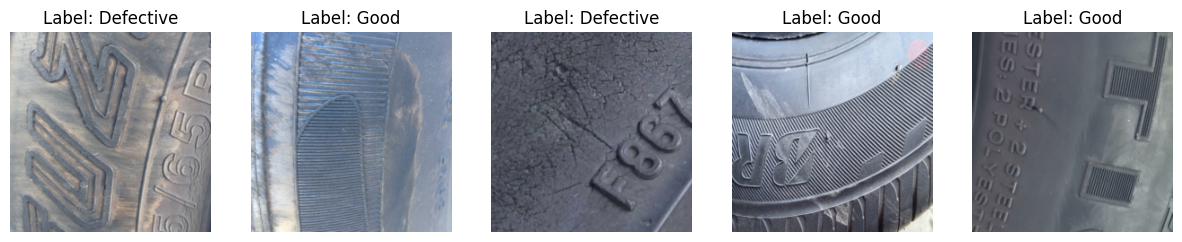

In [ ]:
# Show denormalized images
def visualize_denormalization(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
        image = image * 0.229 + 0.485  # Denormalization
        image = image.clip(0, 1)  # [0, 1] range

        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {'Good' if label == 0 else 'Defective'}")
    plt.show()

visualize_denormalization(dataset)

Data augmentation

In [12]:
# we will add augmentation
augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),       # Randomly flip the image horizontally with a probability of 50%
    transforms.RandomRotation(10),           # Randomly rotate the image by up to 10 degrees
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),       # Random crop and resize to 224x224 (standard input size for many models) and keep at least 80% of the image
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Adjust brightness, contrast, etc.
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),  # Random affine transformation
    transforms.ToTensor(),                   # Convert PIL image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize using mean and std for pretrained models
])
dataset_augmented = TyreDataset(defective_dir, good_dir, transform=augmented)


In [ ]:
print(len(dataset_augmented))

1856


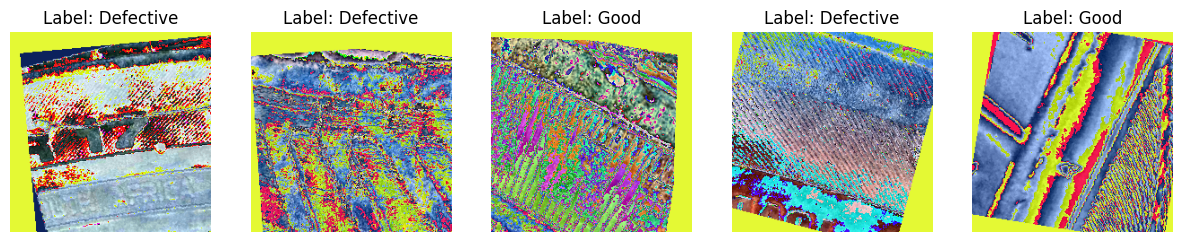

In [ ]:
# Display the first 5 images with labels from augmented dataset
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    image, label = dataset_augmented[i]
    # Convert tensor image back to PIL image for display
    image = transforms.ToPILImage()(image)
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {'Defective' if label == 1 else 'Good'}")
    axes[i].axis('off')

plt.show()

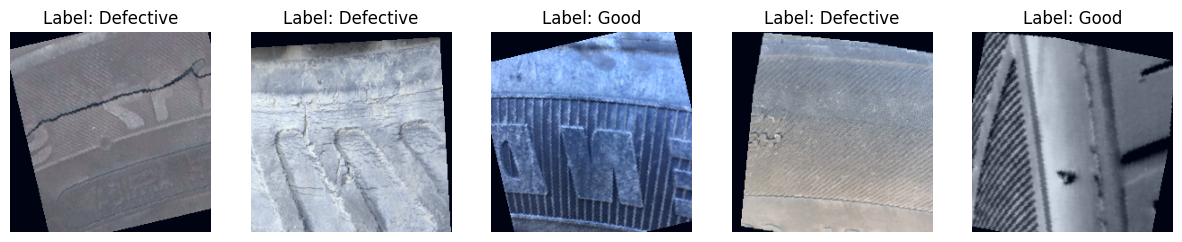

In [ ]:
visualize_denormalization(dataset_augmented)


In [13]:
dataset = torch.utils.data.ConcatDataset([dataset, dataset_augmented])

In [14]:
len(dataset)

3712

Split training and test sets

In [ ]:
dataset_size = len(dataset)

train_size = int(0.8 * dataset_size)  # 80%
test_size = dataset_size - train_size  # 20%

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64

# Create dataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

print(f"train size: {len(train_loader)}")
print(f"test size: {len(test_loader)}")

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
images.shape # (number of examples: 20, number of channels: 3, pixel sizes: 224*224)

(64, 3, 224, 224)

In [ ]:
for data, target in train_loader:
    print(f"Batch size (data): {data.size()}")
    print(f"Batch size (target): {target.size()}")
    break

Batch size (data): torch.Size([64, 3, 224, 224])
Batch size (target): torch.Size([64])


# Modeling with CNN

In [ ]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # convolutional layer (sees 224x224x3 image tensor) batch of 64
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 112x112x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 56x56x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        #max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 28 * 28, 500)
        self.fc2 = nn.Linear(500,10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
model_cnn_base = CNN()
model_cnn_base

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
model_cnn_base.cuda()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
#loss function
criterioncnn = nn.CrossEntropyLoss()
#optimizer
optimizer = optim.SGD(model_cnn_base.parameters(), lr=0.01, momentum=0.9)

In [ ]:
#training the model
num_epochs = 20

valid_loss_min = np.Inf

for epoch in range(1,num_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model_cnn_base.train()
    for data, target in train_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        #optimizer
        optimizer.zero_grad()
        #forward pass
        output = model_cnn_base(data)
        #calculate the batch loss
        loss = criterioncnn(output, target)
        #backward pass
        loss.backward()
        #perform a single optimizer step
        optimizer.step()
        #update training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    model_cnn_base.eval()
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        #forward pass
        output = model_cnn_base(data)
        #calculate the batch loss
        loss = criterioncnn(output, target)
        #update average validation loss
        valid_loss += loss.item()*data.size(0)

    #calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)

    #print trainning validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    #save the model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model_cnn_base.state_dict(), 'model_cnn_base.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.605927 	Validation Loss: 0.557741
Validation loss decreased (inf --> 0.557741).  Saving model ...
Epoch: 2 	Training Loss: 0.590882 	Validation Loss: 0.544205
Validation loss decreased (0.557741 --> 0.544205).  Saving model ...
Epoch: 3 	Training Loss: 0.581091 	Validation Loss: 0.547610
Epoch: 4 	Training Loss: 0.571782 	Validation Loss: 0.557686
Epoch: 5 	Training Loss: 0.585099 	Validation Loss: 0.524154
Validation loss decreased (0.544205 --> 0.524154).  Saving model ...
Epoch: 6 	Training Loss: 0.560198 	Validation Loss: 0.540374
Epoch: 7 	Training Loss: 0.562542 	Validation Loss: 0.546621
Epoch: 8 	Training Loss: 0.565133 	Validation Loss: 0.536890
Epoch: 9 	Training Loss: 0.558990 	Validation Loss: 0.529558
Epoch: 10 	Training Loss: 0.548126 	Validation Loss: 0.544891
Epoch: 11 	Training Loss: 0.546343 	Validation Loss: 0.529821
Epoch: 12 	Training Loss: 0.533243 	Validation Loss: 0.527466
Epoch: 13 	Training Loss: 0.516505 	Validation Loss: 0.543328
E

##Test the Trained Network

In [ ]:
model_cnn_base.load_state_dict(torch.load('model_cnn_base.pt'))


<ipython-input-50-63c199bb5cb3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_cnn_base.load_state_dict(torch.load('model_cnn_base.pt'))


<All keys matched successfully>

In [ ]:
#track the test lost
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
size = len(test_loader.dataset)
predictions = np.zeros(size)
all_classes = np.zeros(size)
all_probs = np.zeros((size, 10))
idx = 0

model_cnn_base.eval()

#iterate over test data
for data, target in test_loader:
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model_cnn_base(data)
    # calculate the batch loss
    loss = criterioncnn(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    predictions[idx:idx+len(target)] = pred.cpu().numpy()
    all_classes[idx:idx+len(target)] = target.cpu().numpy()
    all_probs[idx:idx+len(target)] = output.detach().cpu().numpy()
    idx = idx + len(target)

    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (str(i)))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.516789

Test Accuracy of     0: 57% (175/307)
Test Accuracy of     1: 84% (334/397)

Test Accuracy (Overall): 72% (509/704)


##Visualize a Batch of Training Data


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
images.shape

(64, 3, 224, 224)

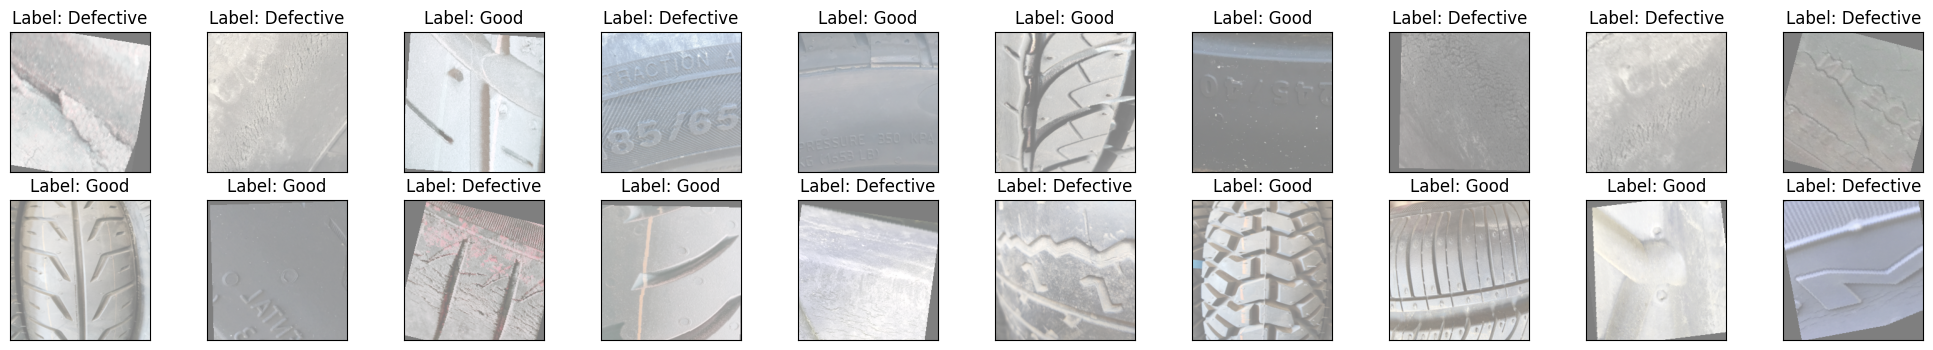

In [ ]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(str(f"Label: {'Defective' if labels[idx].item()== 1 else 'Good'}"))

##Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

Confusion matrix, without normalization
[[214 132]
 [ 63 334]]


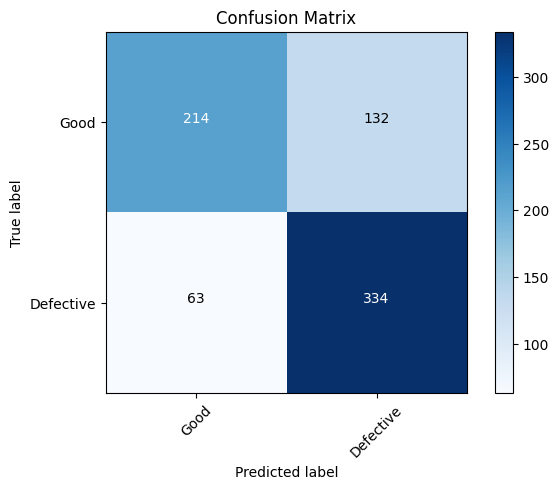

In [ ]:
cm = confusion_matrix(all_classes, predictions)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot the confusion matrix
class_names = ['Good', 'Defective'] # Replace with your actual class names
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')

# Modeling with VGG16


VGG16 model

In [ ]:
class VGG16Classifier:
    def __init__(self, num_classes=2, learning_rate=0.001, device=None):
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_classes = num_classes

        # Load pre-trained VGG16 model
        self.model = models.vgg16(pretrained=True)
        for param in self.model.features.parameters():
            param.requires_grad = False
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
        self.model = self.model.to(self.device)

        # Define loss unction and optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.classifier.parameters(), lr=learning_rate)

    def train(self, train_loader, test_loader, num_epochs=10):
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            # Training loop
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                # Forward pass
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

            # Calculate training accuracy
            train_acc = correct / total
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_acc:.4f}")

            # Evaluate on the test set
            self.evaluate(test_loader)

    def evaluate(self, loader):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_acc = correct / total
        print(f"Test Loss: {running_loss / len(loader):.4f}, Test Accuracy: {test_acc:.4f}")

    def save_model(self, path="vgg16_tyre_model.pth"):
        torch.save(self.model.state_dict(), path)
        print(f"Model saved to {path}")

    def load_model(self, path="vgg16_tyre_model.pth"):
        self.model.load_state_dict(torch.load(path, map_location=self.device))
        self.model = self.model.to(self.device)
        print(f"Model loaded from {path}")


In [ ]:
model_vgg = VGG16Classifier(num_classes=2, learning_rate=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Check the device of the model's first parameter to confirm if it's on GPU or CPU
print(next(model_vgg.model.parameters()).device)


cuda:0


In [ ]:
model_vgg.train(train_loader, test_loader, num_epochs=20)

Epoch [1/20], Loss: 0.4256, Accuracy: 0.9751
Test Loss: 0.2895, Test Accuracy: 0.9704
Epoch [2/20], Loss: 0.0772, Accuracy: 0.9872
Test Loss: 0.2622, Test Accuracy: 0.9812
Epoch [3/20], Loss: 0.0134, Accuracy: 0.9966
Test Loss: 0.2587, Test Accuracy: 0.9758
Epoch [4/20], Loss: 0.0375, Accuracy: 0.9939
Test Loss: 0.2075, Test Accuracy: 0.9866
Epoch [5/20], Loss: 0.0129, Accuracy: 0.9966
Test Loss: 0.2789, Test Accuracy: 0.9812
Epoch [6/20], Loss: 0.0663, Accuracy: 0.9933
Test Loss: 0.3656, Test Accuracy: 0.9704
Epoch [7/20], Loss: 0.0552, Accuracy: 0.9926
Test Loss: 0.4154, Test Accuracy: 0.9731
Epoch [8/20], Loss: 0.0175, Accuracy: 0.9980
Test Loss: 0.3623, Test Accuracy: 0.9839
Epoch [9/20], Loss: 0.0036, Accuracy: 0.9993
Test Loss: 0.4044, Test Accuracy: 0.9812
Epoch [10/20], Loss: 0.0000, Accuracy: 1.0000
Test Loss: 0.4026, Test Accuracy: 0.9839
Epoch [11/20], Loss: 0.0005, Accuracy: 1.0000
Test Loss: 0.3772, Test Accuracy: 0.9812
Epoch [12/20], Loss: 0.0005, Accuracy: 0.9993
Test L

# Modeling with VGG16 enhanced

In [15]:
# Dataset split
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)  # 80% for training
val_size = int(0.1 * dataset_size)    # 10% for validation
test_size = dataset_size - train_size - val_size  # Remaining 10% for testing

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 2969
Validation dataset size: 371
Test dataset size: 372


In [ ]:
import matplotlib.pyplot as plt

class VGG16Classifier_p:
    def __init__(self, num_classes=2, learning_rate=0.001, device=None):
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_classes = num_classes

        # Load pre-trained VGG16 model
        self.model = models.vgg16(pretrained=True)
        for param in self.model.features.parameters():
            param.requires_grad = False
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
        self.model = self.model.to(self.device)

        # Define loss function and optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.classifier.parameters(), lr=learning_rate, weight_decay=1e-4)

        # Lists to store loss and accuracy history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train(self, train_loader, validation_loader, test_loader, num_epochs=10, patience=5):
        best_val_loss = float('inf')  # Initialize best validation loss
        patience_counter = 0  # Counter for early stopping

        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            # Training loop
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                # Forward pass
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

            # Calculate training metrics
            train_loss = running_loss / len(train_loader)
            train_acc = correct / total
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)

            print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

            # Validate on the validation set
            val_loss, val_acc = self.evaluate(validation_loader, mode="Validation")
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            # Early Stopping Logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save the best model
                self.save_model(path="best_model.pth")
                print("Validation loss improved. Model saved.")
            else:
                patience_counter += 1
                print(f"No improvement in validation loss for {patience_counter} epoch(s).")

            # Check if patience is exhausted
            if patience_counter >= patience:
                print("Early stopping triggered. Training terminated.")
                break

        # Optionally, evaluate on the test set
        self.evaluate(test_loader, mode="Test")

    def evaluate(self, loader, mode="Test"):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        acc = correct / total
        avg_loss = running_loss / len(loader)
        print(f"{mode} Loss: {avg_loss:.4f}, {mode} Accuracy: {acc:.4f}")
        return avg_loss, acc

    def save_model(self, path="vgg16_tyre_model.pth"):
        torch.save(self.model.state_dict(), path)
        print(f"Model saved to {path}")

    def load_model(self, path="vgg16_tyre_model.pth"):
        self.model.load_state_dict(torch.load(path, map_location=self.device))
        self.model = self.model.to(self.device)
        print(f"Model loaded from {path}")

    def plot_metrics(self):
        # Plot loss and accuracy curves
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(12, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label="Training Loss", marker='o')
        plt.plot(epochs, self.val_losses, label="Validation Loss", marker='o')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss vs Epochs")
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, label="Training Accuracy", marker='o')
        plt.plot(epochs, self.val_accuracies, label="Validation Accuracy", marker='o')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Accuracy vs Epochs")
        plt.legend()

        plt.tight_layout()
        plt.show()


In [ ]:
classifier = VGG16Classifier_p(num_classes=2, learning_rate=0.001)
classifier.train(train_loader, val_loader, test_loader, num_epochs=50, patience=5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 123MB/s]


Epoch [1/50], Training Loss: 0.7129, Training Accuracy: 0.8147
Validation Loss: 0.7163, Validation Accuracy: 0.8162
Model saved to best_model.pth
Validation loss improved. Model saved.
Epoch [2/50], Training Loss: 0.2536, Training Accuracy: 0.9272
Validation Loss: 0.2992, Validation Accuracy: 0.9351
Model saved to best_model.pth
Validation loss improved. Model saved.
Epoch [3/50], Training Loss: 0.0494, Training Accuracy: 0.9852
Validation Loss: 0.2968, Validation Accuracy: 0.9243
Model saved to best_model.pth
Validation loss improved. Model saved.
Epoch [4/50], Training Loss: 0.0186, Training Accuracy: 0.9926
Validation Loss: 0.6663, Validation Accuracy: 0.8973
No improvement in validation loss for 1 epoch(s).
Epoch [5/50], Training Loss: 0.0528, Training Accuracy: 0.9858
Validation Loss: 0.7299, Validation Accuracy: 0.9189
No improvement in validation loss for 2 epoch(s).
Epoch [6/50], Training Loss: 0.1180, Training Accuracy: 0.9818
Validation Loss: 0.9120, Validation Accuracy: 0.92

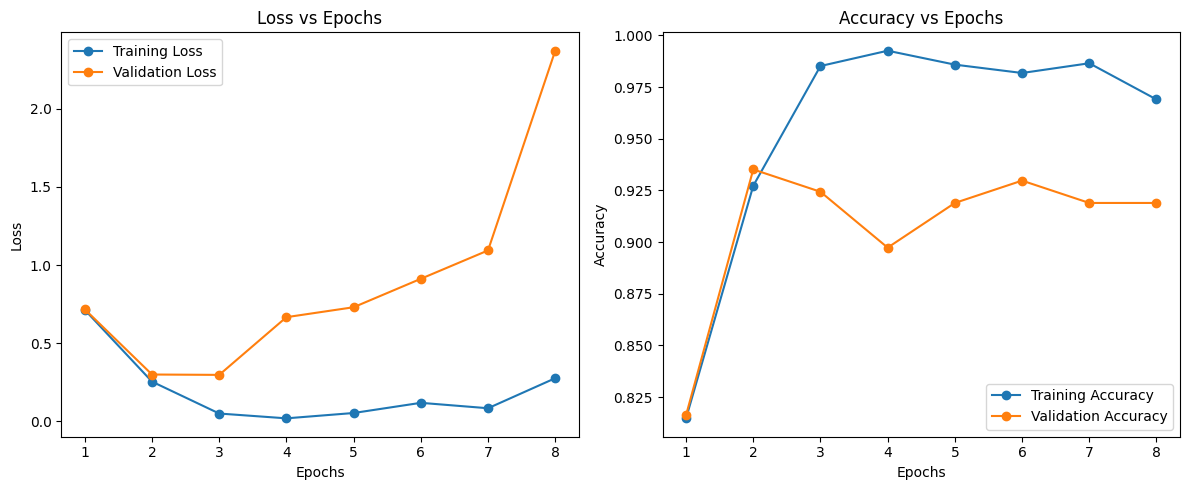

In [ ]:
classifier.plot_metrics()

In [ ]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

class VGG16Classifier_p:
    def __init__(self, num_classes=2, learning_rate=0.001, device=None):
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_classes = num_classes

        # Load pre-trained VGG16 model
        self.model = models.vgg16(pretrained=True)
        for param in self.model.features.parameters():
            param.requires_grad = False
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
        self.model = self.model.to(self.device)

        # Define loss function and optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.classifier.parameters(), lr=learning_rate, weight_decay=1e-4)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=2, verbose=True)

        # Lists to store loss and accuracy history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train(self, train_loader, validation_loader, test_loader, num_epochs=10, patience=5):
        best_val_loss = float('inf')  # Initialize best validation loss
        patience_counter = 0  # Counter for early stopping

        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            # Training loop
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                # Forward pass
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

            # Calculate training metrics
            train_loss = running_loss / len(train_loader)
            train_acc = correct / total
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)

            print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

            # Validate on the validation set
            val_loss, val_acc = self.evaluate(validation_loader, mode="Validation")
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            # Early Stopping Logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save the best model
                self.save_model(path="best_model.pth")
                print("Validation loss improved. Model saved.")
            else:
                patience_counter += 1
                print(f"No improvement in validation loss for {patience_counter} epoch(s).")

            # Check if patience is exhausted
            if patience_counter >= patience:
                print("Early stopping triggered. Training terminated.")
                break

        # Optionally, evaluate on the test set
        self.evaluate(test_loader, mode="Test")

    def evaluate(self, loader, mode="Test"):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        acc = correct / total
        avg_loss = running_loss / len(loader)
        print(f"{mode} Loss: {avg_loss:.4f}, {mode} Accuracy: {acc:.4f}")
        return avg_loss, acc

    def save_model(self, path="vgg16_tyre_model.pth"):
        torch.save(self.model.state_dict(), path)
        print(f"Model saved to {path}")

    def load_model(self, path="vgg16_tyre_model.pth"):
        self.model.load_state_dict(torch.load(path, map_location=self.device))
        self.model = self.model.to(self.device)
        print(f"Model loaded from {path}")

    def plot_metrics(self):
        # Plot loss and accuracy curves
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(12, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label="Training Loss", marker='o')
        plt.plot(epochs, self.val_losses, label="Validation Loss", marker='o')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss vs Epochs")
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, label="Training Accuracy", marker='o')
        plt.plot(epochs, self.val_accuracies, label="Validation Accuracy", marker='o')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Accuracy vs Epochs")
        plt.legend()

        plt.tight_layout()
        plt.show()

In [ ]:
classifier = VGG16Classifier_p(num_classes=2, learning_rate=1e-4)
classifier.train(train_loader, val_loader, test_loader, num_epochs=50, patience=5)

Epoch [1/50], Training Loss: 0.3000, Training Accuracy: 0.8649
Validation Loss: 0.1952, Validation Accuracy: 0.9191
Model saved to best_model.pth
Validation loss improved. Model saved.
Epoch [2/50], Training Loss: 0.1366, Training Accuracy: 0.9448
Validation Loss: 0.1589, Validation Accuracy: 0.9353
Model saved to best_model.pth
Validation loss improved. Model saved.
Epoch [3/50], Training Loss: 0.1051, Training Accuracy: 0.9562
Validation Loss: 0.1497, Validation Accuracy: 0.9407
Model saved to best_model.pth
Validation loss improved. Model saved.
Epoch [4/50], Training Loss: 0.0849, Training Accuracy: 0.9680
Validation Loss: 0.1259, Validation Accuracy: 0.9353
Model saved to best_model.pth
Validation loss improved. Model saved.
Epoch [5/50], Training Loss: 0.0781, Training Accuracy: 0.9687
Validation Loss: 0.1506, Validation Accuracy: 0.9461
No improvement in validation loss for 1 epoch(s).
Epoch [6/50], Training Loss: 0.0588, Training Accuracy: 0.9757
Validation Loss: 0.1677, Valida

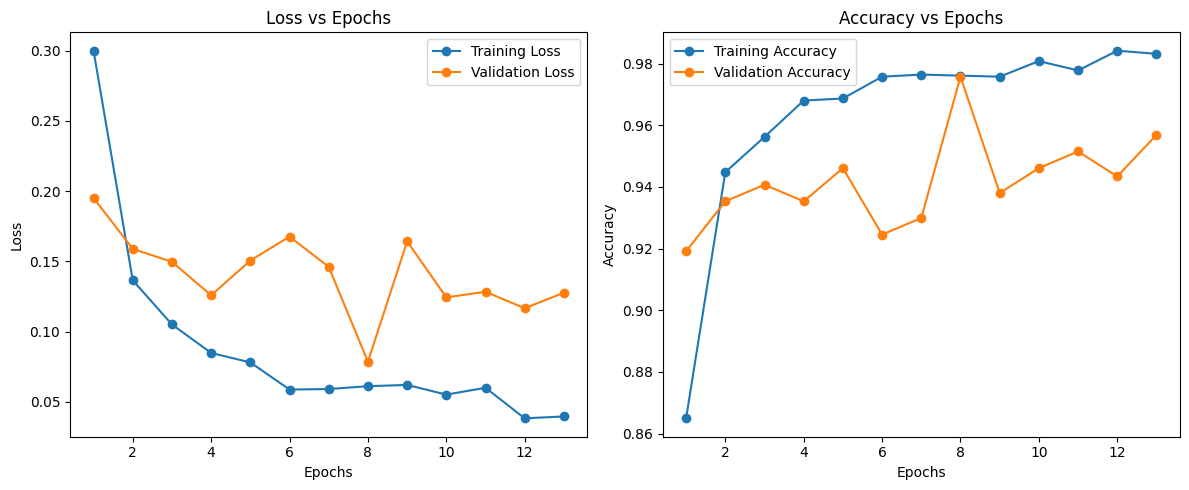

In [ ]:
classifier.plot_metrics()

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np


class VGG16Classifier_output:
    def __init__(self, num_classes=2, learning_rate=0.001, device=None):
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_classes = num_classes

        # Load pre-trained VGG16 model
        self.model = models.vgg16(pretrained=True)
        for param in self.model.features.parameters():
            param.requires_grad = False
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
        self.model = self.model.to(self.device)

        # Define loss function and optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.classifier.parameters(), lr=learning_rate, weight_decay=1e-4)

        # Lists to store loss and accuracy history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train(self, train_loader, validation_loader, test_loader, num_epochs=10, patience=5):
        best_val_loss = float('inf')  # Initialize best validation loss
        patience_counter = 0  # Counter for early stopping

        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            # Training loop
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                # Forward pass
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

            # Calculate training metrics
            train_loss = running_loss / len(train_loader)
            train_acc = correct / total
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)

            print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

            # Validate on the validation set
            val_loss, val_acc = self.evaluate(validation_loader, mode="Validation")
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            # Early Stopping Logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save the best model
                self.save_model(path="best_model.pth")
                print("Validation loss improved. Model saved.")
            else:
                patience_counter += 1
                print(f"No improvement in validation loss for {patience_counter} epoch(s).")

            # Check if patience is exhausted
            if patience_counter >= patience:
                print("Early stopping triggered. Training terminated.")
                break

        # Evaluate on the test set
        self.evaluate(test_loader, mode="Test")

    def evaluate(self, loader, mode="Test", return_outputs=False, num_images=10):
        """
        Evaluate the model on the given data loader and optionally return outputs for visualization.

        Args:
            loader (DataLoader): DataLoader for evaluation (e.g., test or validation set).
            mode (str): Mode for evaluation (e.g., "Test" or "Validation").
            return_outputs (bool): Whether to return outputs (images, labels, predictions).
            num_images (int): Number of images to return if return_outputs is True.

        Returns:
            avg_loss (float): Average loss over the loader.
            accuracy (float): Accuracy over the loader.
            images (list, optional): List of images (only returned if return_outputs=True).
            labels (list, optional): List of labels (only returned if return_outputs=True).
            predictions (list, optional): List of predictions (only returned if return_outputs=True).
        """
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        predictions = []
        labels = []
        images = []

        with torch.no_grad():
            for images_batch, labels_batch in loader:
                images_batch, labels_batch = images_batch.to(self.device), labels_batch.to(self.device)

                # Forward pass
                outputs = self.model(images_batch)
                loss = self.criterion(outputs, labels_batch)
                running_loss += loss.item()

                _, predicted = outputs.max(1)
                correct += (predicted == labels_batch).sum().item()
                total += labels_batch.size(0)

                if return_outputs:
                    # Save data for visualization
                    predictions.extend(predicted.cpu().numpy())
                    labels.extend(labels_batch.cpu().numpy())
                    images.extend(images_batch.cpu())

        avg_loss = running_loss / len(loader)
        accuracy = correct / total

        print(f"{mode} Loss: {avg_loss:.4f}, {mode} Accuracy: {accuracy:.4f}")

        if return_outputs:
            # Return first `num_images` for visualization
            return avg_loss, accuracy, images[:num_images], labels[:num_images], predictions[:num_images]
        else:
            return avg_loss, accuracy


    def save_model(self, path="vgg16_tyre_model.pth"):
        torch.save(self.model.state_dict(), path)
        print(f"Model saved to {path}")

    def load_model(self, path="vgg16_tyre_model.pth"):
        self.model.load_state_dict(torch.load(path, map_location=self.device))
        self.model = self.model.to(self.device)
        print(f"Model loaded from {path}")

    def plot_metrics(self):
        # Plot loss and accuracy curves
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(12, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label="Training Loss", marker='o')
        plt.plot(epochs, self.val_losses, label="Validation Loss", marker='o')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss vs Epochs")
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, label="Training Accuracy", marker='o')
        plt.plot(epochs, self.val_accuracies, label="Validation Accuracy", marker='o')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Accuracy vs Epochs")
        plt.legend()

        plt.tight_layout()
        plt.show()


In [19]:
classifier = VGG16Classifier_output(num_classes=2, learning_rate=1e-4)
classifier.train(train_loader, val_loader, test_loader, num_epochs=50, patience=5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Training Loss: 0.3252, Training Accuracy: 0.8602
Validation Loss: 0.1935, Validation Accuracy: 0.9191
Model saved to best_model.pth
Validation loss improved. Model saved.
Epoch [2/50], Training Loss: 0.1334, Training Accuracy: 0.9407
Validation Loss: 0.1660, Validation Accuracy: 0.9299
Model saved to best_model.pth
Validation loss improved. Model saved.
Epoch [3/50], Training Loss: 0.1013, Training Accuracy: 0.9589
Validation Loss: 0.1575, Validation Accuracy: 0.9434
Model saved to best_model.pth
Validation loss improved. Model saved.
Epoch [4/50], Training Loss: 0.0921, Training Accuracy: 0.9603
Validation Loss: 0.1275, Validation Accuracy: 0.9515
Model saved to best_model.pth
Validation loss improved. Model saved.
Epoch [5/50], Training Loss: 0.0785, Training Accuracy: 0.9670
Validation Loss: 0.1280, Validation Accuracy: 0.9434
No improvement in validation loss for 1 epoch(s).
Epoch [6/50], Training Loss: 0.0650, Training Accuracy: 0.9710
Validation Loss: 0.1476, Valida

Test Loss: 0.1361, Test Accuracy: 0.9409


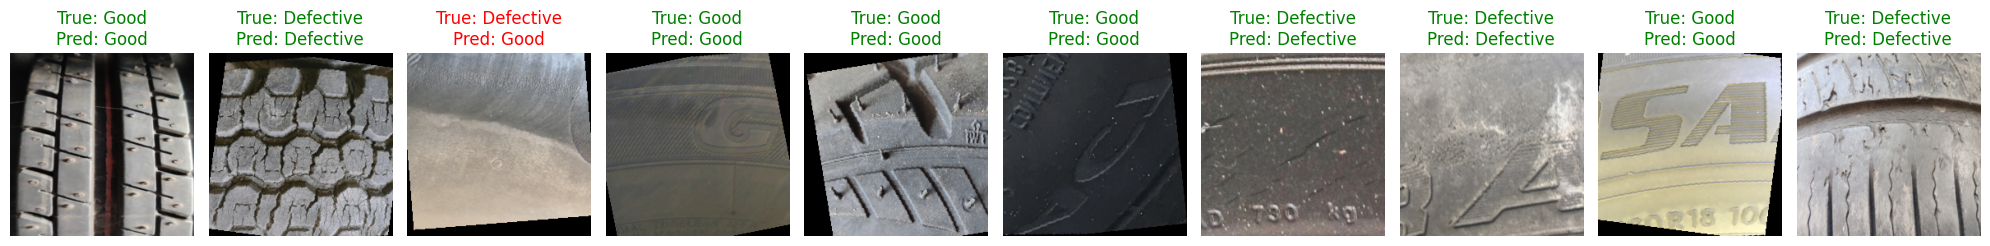

In [20]:
# Evaluate the model and return outputs for visualization
avg_loss, accuracy, images, labels, predictions = classifier.evaluate(test_loader, mode="Test", return_outputs=True)

def visualize_predictions(images, labels, predictions, class_names):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))

    for i in range(len(images)):
        # Denormalization
        image = images[i].clone()
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        for t, m, s in zip(image, mean, std):
            t.mul_(s).add_(m)
        image = image.permute(1, 2, 0).numpy().clip(0, 1)

        axes[i].imshow(image)
        axes[i].set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[predictions[i]]}",
                          color="green" if labels[i] == predictions[i] else "red")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualization of test set
class_names = ["Good", "Defective"]
visualize_predictions(images, labels, predictions, class_names)



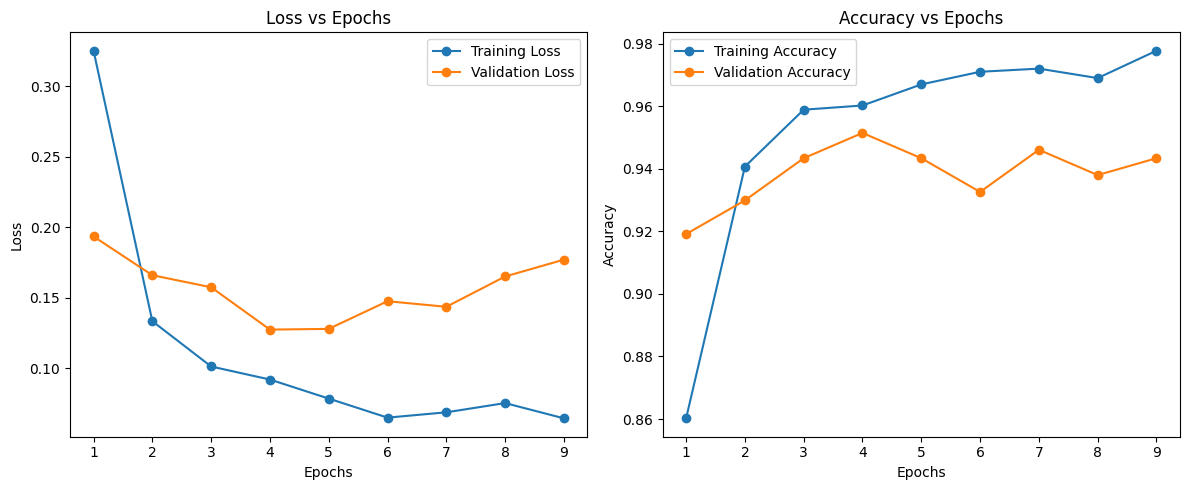

In [21]:
classifier.plot_metrics()